In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
from utils import *
import random

### Reading the Log File

In [21]:
coloms = ['Center','Steering','Throttle','Brake','Speed']
data = pd.read_csv('Data/driving_log.csv',names= coloms)
#data.head()
#print(data['Center'][0])
#print(data['Center'][0].split('\\')[-1])
data['Center'] = data['Center'].apply(lambda x:x.split('\\')[-1])
data.head()

,Center,Steering,Throttle,Brake,Speed
0,center_2021_03_16_17_13_49_883.jpg,0.00,1.0,0,11.53841
1,center_2021_03_16_17_13_49_956.jpg,0.00,1.0,0,12.55821
2,center_2021_03_16_17_13_50_023.jpg,0.00,1.0,0,13.10373
3,center_2021_03_16_17_13_50_095.jpg,-0.15,1.0,0,14.21047
4,center_2021_03_16_17_13_50_166.jpg,-0.30,1.0,0,14.59783


### Balance Steering Data in a certain Range

[-0.96774194 -0.90322581 -0.83870968 -0.77419355 -0.70967742 -0.64516129
 -0.58064516 -0.51612903 -0.4516129  -0.38709677 -0.32258065 -0.25806452
 -0.19354839 -0.12903226 -0.06451613  0.          0.06451613  0.12903226
  0.19354839  0.25806452  0.32258065  0.38709677  0.4516129   0.51612903
  0.58064516  0.64516129  0.70967742  0.77419355  0.83870968  0.90322581
  0.96774194]


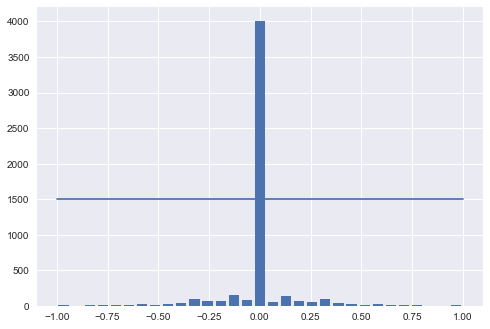

In [22]:
nBins = 31
sampleBins = 1500
hist, bins = np.histogram(data['Steering'],nBins)
#print(bins)
#As the zero is not present in bins and most of the time our steering will be on zero degree
centerPoint = (bins[:-1] + bins[1:])*0.5
print(centerPoint)
plt.bar(centerPoint,hist,width=0.05)
plt.plot((-1,1),(sampleBins,sampleBins))
plt.show()

In [23]:
#As we can see that the value zero is exceeding as compare to other values 
#So we are limiting 500 values from each bins
removeIndex = []
for i in range(nBins-1):
    binDataList = []
    for j in range(len(data['Steering'])):
        if(data['Steering'][j] >= centerPoint[i] and data['Steering'][j] <= centerPoint[i+1]):
            binDataList.append(j)
    binDataList = shuffle(binDataList)
    binDataList = binDataList[sampleBins:]
    removeIndex.extend(binDataList)
print("Removed Images : ",len(removeIndex))
data.drop(data.index[removeIndex],inplace=True)
print("Remaining Images: ",len(data))


Removed Images :  5145
Remaining Images:  1623


### Visualize the final data that we are going to use

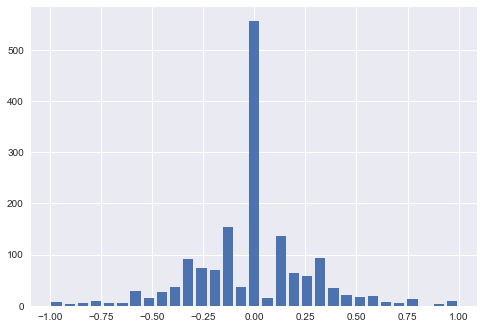

In [24]:
hist, _ = np.histogram(data['Steering'],nBins)
plt.bar(centerPoint,hist,width = 0.05)

plt.show()

### Data Cleaning

In [25]:
#Convert Data from pandas to numpy library for easy processing
#Create and array to store images path in an array
imagesPath = []
#Create an array to store the steering angle
steeringAngle = []

for i in range(len(data)):
    rowData = data.iloc[i]
    #print(rowData)
    #print(os.path.join('Data','IMG',rowData[0]))
    imagesPath.append(os.path.join('Data','IMG',rowData[0]))
    steeringAngle.append(rowData[1])
imagesPath = np.asarray(imagesPath)
steeringAngle = np.asarray(steeringAngle)
#print(imagesPath)
#print(steeringAngle)

### Splitting the data into the Train and Test

In [26]:

xTrain,xTest, yTrain, yTest = train_test_split(imagesPath,steeringAngle,test_size=0.2,random_state=5)
print(len(xTrain))
print(len(xTest))


1298
325


### Augmenting the Image

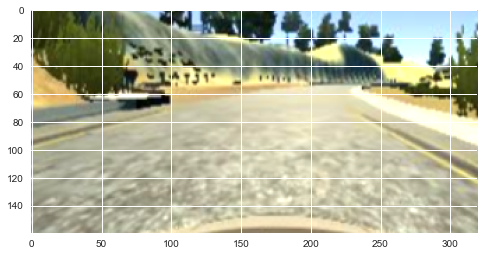

In [27]:

#To add variety to our image data we are using augmentation by applying some slight modifications
def applyAug(Path,steering):
    img = mpimg.imread(Path)
    or_img = mpimg.imread(Path)
    if np.random.rand() < 0.5:
    #Applying Translation to images (PAN)
        pan = iaa.Affine(translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)})
        img = pan.augment_image(img)
    #Applying zoom to image
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1,1.3))
        img = zoom.augment_image(img)
    #Alter the brightness of the image
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.5,1.3))
        img = brightness.augment_image(img)
    #Flip the imgae 
    if np.random.rand() < 0.5:
        img = cv2.flip(img,1)
        steering = - steering
        
    return img, steering
    #-----------Neg the steering angle here

#Testing
img , steering = applyAug('img.jpg',0)
plt.imshow(img)
plt.show()



###  Preprocessing the Image Data

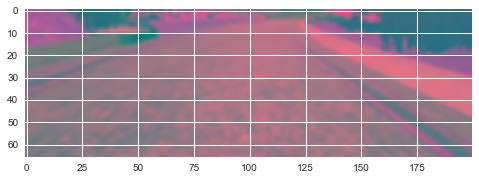

In [28]:
def preprocess(img):
    #Crop the image in a certain way that only the lanes are roads are visible
    img = img[60:140,:,:]
    #Convert the RGD image to YUV as per the NVIDIA's paper so the lanes get more highlighted
    img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    img = cv2.resize(img,(200,66))
    #Apply blur 
    img = cv2.GaussianBlur(img,(3,3),0)
    #Normalize the value which is 0-255 to 0-1
    img = img/255
    
    return img


#Testing
img  = preprocess(mpimg.imread('img.jpg'))
plt.imshow(img)
plt.show()



### Batch Generator
##### The Idea here is we do not send all of uor images to our model instead we send images in batches this could help us in generalization, So before sending our image to model we should augment our image as well as preprocess it


In [29]:
def batchGenerator(imgPath, steerList, batchSize, Flag):
    while True:
        imageBatch = []
        steeringBatch = []
        
        for i in range(batchSize):
            index = random.randint(0,len(imgPath)-1)
            if Flag:
                img, steering = applyAug(imgPath[index],steerList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steerList[index]
            img = preprocess(img)
            imageBatch.append(img)
            steeringBatch.append(steering)
        
        yield(np.asarray(imageBatch),np.asarray(steeringBatch))
        

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Dense,Flatten
from tensorflow.keras.optimizers import Adam

In [31]:
model = Sequential()

model.add(Convolution2D(24,(5,5),(2,2),input_shape=(66,200,3),activation='elu'))
model.add(Convolution2D(36,(5,5),(2,2),activation='elu'))
model.add(Convolution2D(48,(5,5),(2,2),activation='elu'))
model.add(Convolution2D(64,(3,3),activation='elu'))
model.add(Convolution2D(64,(3,3),activation='elu'))

model.add(Flatten())

model.add(Dense(100,activation='elu'))
model.add(Dense(50,activation='elu'))
model.add(Dense(10,activation='elu'))
model.add(Dense(1))


model.compile(Adam(lr=0.0001),loss = 'mse')
model.summary()

          




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [37]:
history = model.fit(batchGenerator(xTrain,yTrain,100,1),steps_per_epoch=300,epochs=10,
          validation_data=batchGenerator(xTest,yTest,100,0),validation_steps=200)


Epoch 1/10
300/300 [==============================] - 383s 1s/step - loss: 0.0728 - val_loss: 0.0940
Epoch 2/10
300/300 [==============================] - 376s 1s/step - loss: 0.0644 - val_loss: 0.0994
Epoch 3/10
300/300 [==============================] - 356s 1s/step - loss: 0.0587 - val_loss: 0.0999
Epoch 4/10
300/300 [==============================] - 365s 1s/step - loss: 0.0558 - val_loss: 0.1108
Epoch 5/10
300/300 [==============================] - 364s 1s/step - loss: 0.0537 - val_loss: 0.1047
Epoch 6/10
300/300 [==============================] - 353s 1s/step - loss: 0.0508 - val_loss: 0.1158
Epoch 7/10
300/300 [==============================] - 360s 1s/step - loss: 0.0496 - val_loss: 0.1150
Epoch 8/10
300/300 [==============================] - 355s 1s/step - loss: 0.0473 - val_loss: 0.1124
Epoch 9/10
300/300 [==============================] - 358s 1s/step - loss: 0.0461 - val_loss: 0.1101
Epoch 10/10
300/300 [==============================] - 355s 1s/step - loss: 0.0450 - val_lo

Model Saved Succesfully


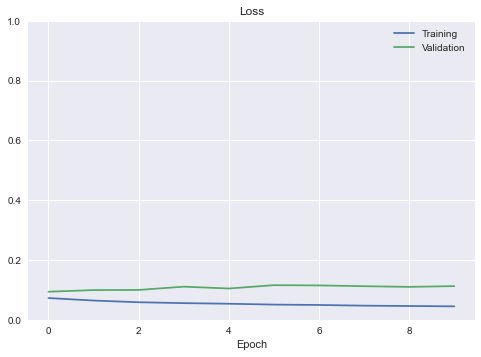

In [38]:
model.save('selfDriveModel.h5')
print("Model Saved Succesfully")
plt.style.use('seaborn')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.ylim(0,1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()
